In [ ]:
# Import Packages
import pandas as pd
from clean_task1 import load_data, relabel_factors
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
import statsmodels.formula.api as smf
import seaborn as sns
import numpy as np


# Set necessary configs
pd.set_option('display.max_columns', None)


In [2]:
# Read the data and select the headers
df = load_data("../data_source/CDS_25_Task1.xlsx")
df = relabel_factors(df)

In [3]:
# For demographic variables, what are the distributions of categories
print(df["Country"].value_counts())
print(df["Industry"].value_counts())
print(df["Gender"].value_counts())
print(df["Age"].value_counts())

Country
US    1204
UK     617
DE     613
IT     600
FR     593
SP     584
Name: count, dtype: int64
Industry
Fin       1797
Tech      1211
Energy     617
Pharma     586
Name: count, dtype: int64
Gender
Male                           2113
Female                         2062
Non-Binary / Non-Conforming      28
Prefer Not to Answer              7
Other                             1
Name: count, dtype: int64
Age
25-40    1493
41-64    1413
18-24    1305
Name: count, dtype: int64


From printing the discrete data, it is clear to see that the labelling of the data is correct with no notable mistakes.

In [4]:
# Understand the summary statistics of the quantitative data that has been provided
df.describe()

,"Extraverted, Enthusiastic.","Critical, Quarrelsome.","Dependable, Self-Disciplined.","Anxious, Easily Upset.","Open To New Experiences, Complex.","Sympathetic, Warm.","Disorganized, Careless.","Reserved, Quiet.","Calm, Emotionally Stable.","Conventional, Uncreative.",Preparedness Levels,lbalanx,lbalsat,lcntcom,lcntpsy,lconinc,lconsoc,lcontcon,lcontimp,lgen,ljouopt,ljoupro,lresfin,lresski,ltraaut,ltrades,lcarprom,lcollea,lenjhyb,lexcesswk,lfinlair,llearndev,lmeanfull,lpoorman,ltoxic,luseskills,lwellcomp,fbalanx,fbalsat,fcntcom,fcntpsy,fconinc,fconsoc,fcontcon,fcontimp,fgen,fjouopt,fjoupro,fresfin,fresski,ftraaut,ftrades,fcarprom,fcollea,fenjhyb,fexcesswk,ffinfair,flearndev,fmeanfull,fpoorman,ftoxic,fuseskills,fwellcomp
count,4211.00000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4210.000000,4210.000000,4211.000000,4210.000000,4211.000000,4211.000000,4210.000000,4211.000000,4210.000000,4211.000000,4211.000000,4211.000000,4211.000000,4209.000000,4210.000000,4210.000000,4210.000000,4211.000000,4209.000000,4206.000000,4211.000000,4211.000000,4210.000000,4210.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4208.000000,4209.000000,4211.000000
mean,4.95488,3.432201,5.818095,3.679886,5.606982,5.730705,2.909998,4.895987,5.493707,3.554738,7.472833,-4.779150,28.823320,24.691285,36.784612,36.731180,-15.685110,46.259796,55.414391,50.771788,33.994301,44.621230,37.431726,56.613631,48.705771,40.916647,69.644977,26.953218,72.239373,60.071259,44.358670,76.715744,73.705463,35.775350,39.076229,78.248219,62.651389,6.960553,26.744474,23.314619,17.681544,16.655882,4.194921,27.885788,38.644207,28.238600,21.896601,25.839528,25.425381,30.111985,29.060262,29.225229,69.037642,41.029522,64.422099,53.841680,49.683340,68.582701,66.819313,44.444233,49.103114,71.981701,63.888865
std,1.70241,1.941752,1.397373,1.971079,1.450412,1.343288,1.936577,1.702342,1.418957,1.909853,1.549455,59.445068,59.836365,55.240994,53.111753,54.523371,55.271944,48.958492,52.014756,49.591542,56.351282,52.926631,54.198323,48.156787,50.042610,54.595928,31.426853,32.728494,28.858047,33.850743,35.446842,27.610623,29.394357,36.010006,36.086813,26.880258,32.758645,36.595440,44.621083,41.344062,36.057745,40.645781,34.068648,37.079739,42.492728,36.911896,41.705553,38.899262,38.652429,37.228426,38.424302,39.021322,27.542660,26.091817,25.486879,30.178710,23.719157,25.985147,26.850804,29.558356,28.220659,25.287965,29.280311
min,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-94.444444,-96.666667,-98.888889,-97.222222,-98.888889,-98.888889,-96.666667,-98.888889,-96.666667,-96.666667,-98.888889,-98.888889,-98.888889,-96.111111,-98.888889,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.00000,2.000000,5.000000,2.000000,5.000000,5.000000,1.000000,4.000000,5.000000,2.000000,6.500000,-50.000000,0.000000,0.000000,0.000000,0.000000,-50.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,25.000000,0.000000,0.000000,50.000000,0.000000,50.000000,25.000000,0.000000,75.000000,50.000000,0.000000,0.000000,75.000000,50.000000,-17.777778,-4.444444,-5.555556,-6.111111,-10.277778,-18.888889,5.555556,10.000000,4.444444,-6.944444,0.000000,-1.111111,7.777778,5.555556,3.333333,54.444444,21.111111,51.679293,26.666667,34.444444,57.777778,54.444444,20.000000,26.666667,61.666667,40.000000
50%,5.00000,3.

In [5]:
# The qualitative summary statistics indicate that there are a very small number of missing rows, which will be dropped
df = df.dropna()

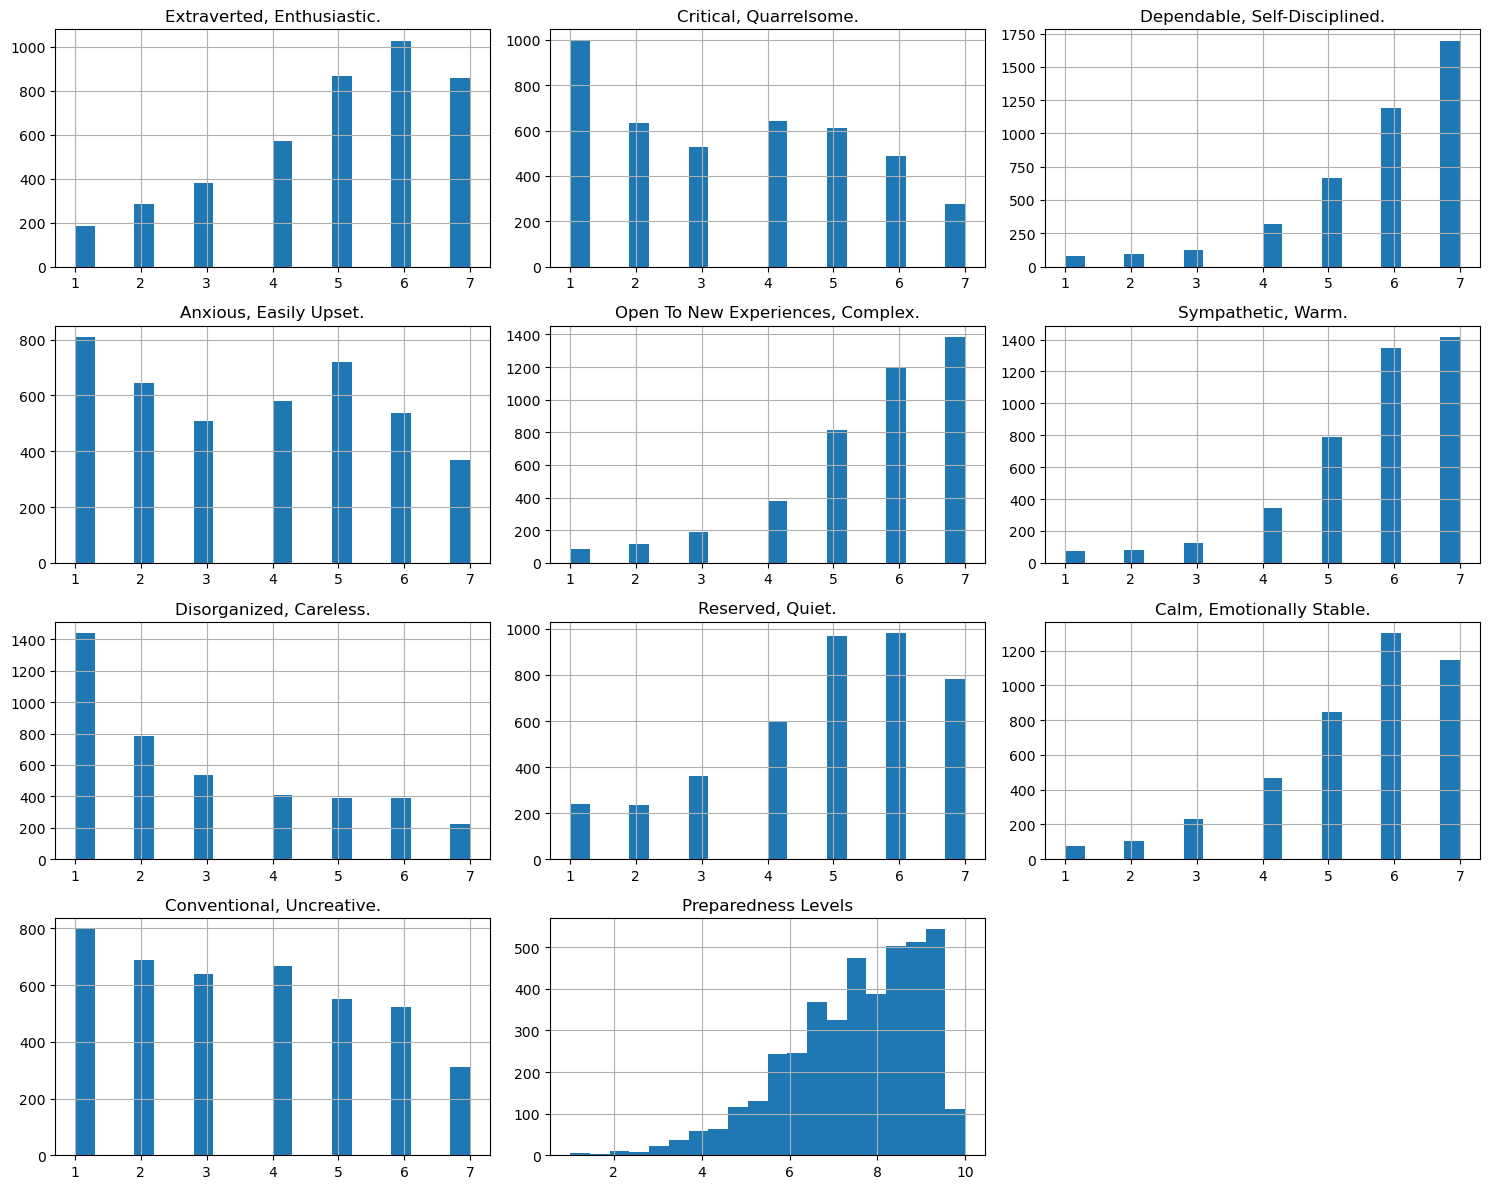

In [6]:
# Plot a matrix of histograms to inspect distribution of variables
df_subset = df.iloc[:, 5:16]
df_subset.hist(figsize=(15, 12), bins=20)

plt.tight_layout()
plt.show()

All personality factors are measured on a scale from 1-7, whilst the outcome variable 'Preparedness Levels' is from a scale of 1-10. 

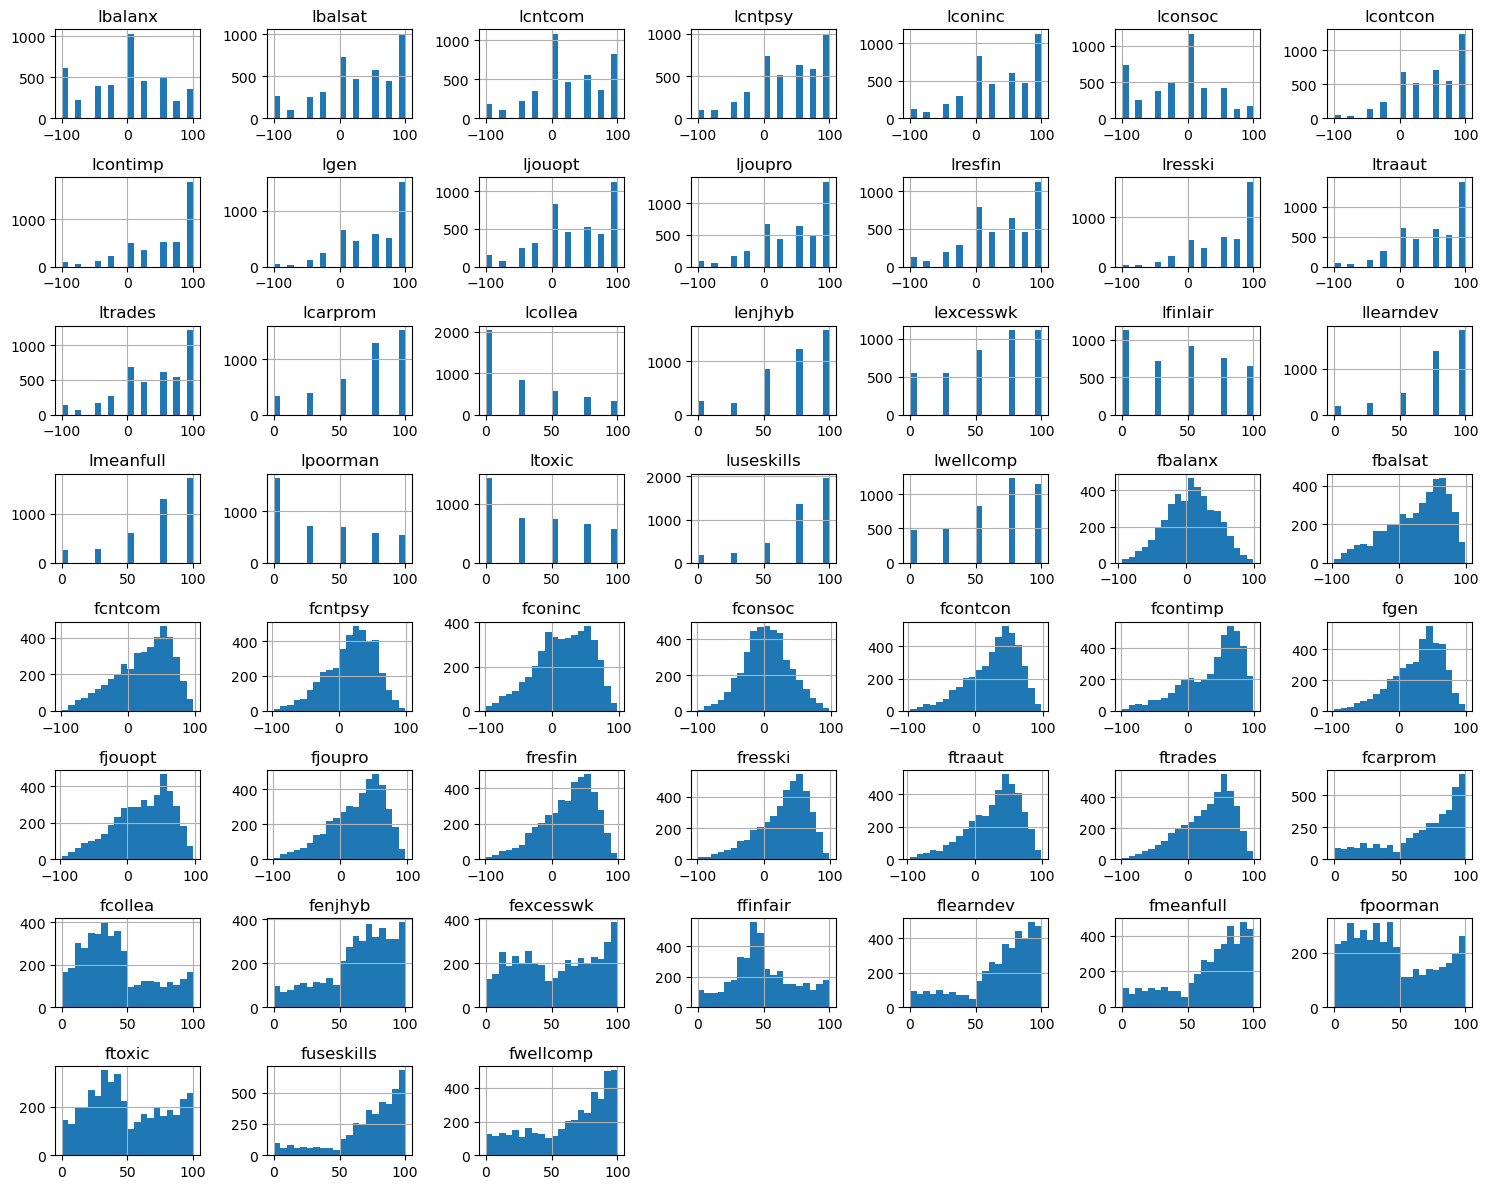

In [7]:
# Plot a matrix of histograms to inspect distribution of variables
df_subset = df.iloc[:, 16:]
df_subset.hist(figsize=(15, 12), bins=20)

plt.tight_layout()
plt.show()

From plotting the distributions of the variables, two scales are clearly apparent:
1. Emotional/psychological variables are encoded on a scale from -100 to 100 for both implicit and explicit variables
2. Workplace/functional variables are encoded on a scale from 0 to 100 for both implicit and explicit variables

There are also interesting trends to note here, the distribution of variables appear to be quite interesting.

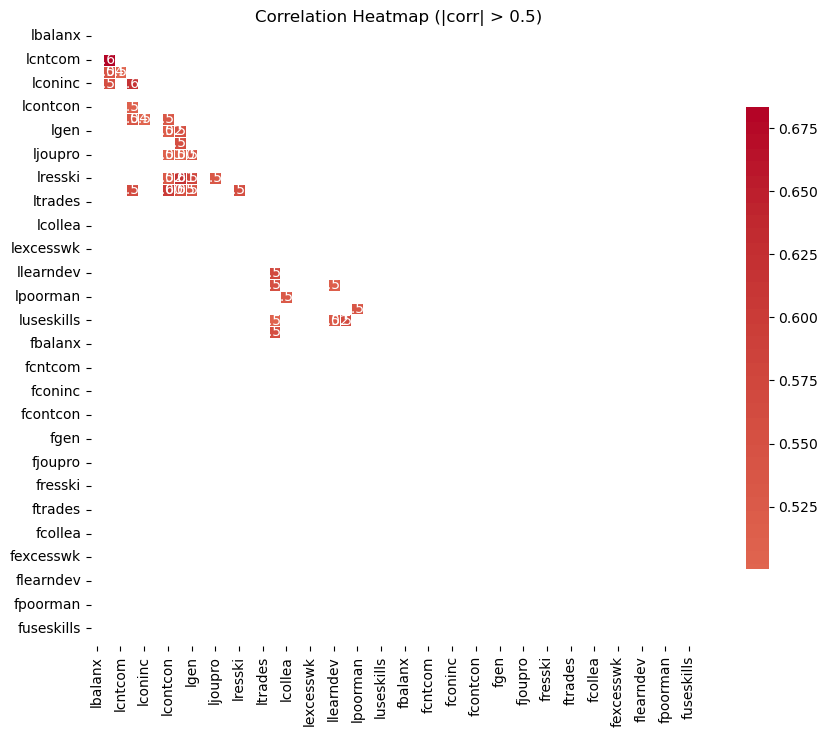

In [22]:
# Identify collinearity between variables
corr = df.iloc[:,17:].corr()

threshold = 0.5
filtered_corr = corr.where(abs(corr) > threshold, other=np.nan)

mask = np.triu(np.ones_like(filtered_corr, dtype=bool))

plt.figure(figsize=(10,8))
sns.heatmap(
    filtered_corr,
    mask=mask,
    annot=True,
    cmap='coolwarm',
    center=0,
    linewidths=0.5,
    cbar_kws={"shrink": 0.75},
    fmt=".2f",
    square=True
)
plt.title(f"Correlation Heatmap (|corr| > {threshold})")
plt.show()

### Identify the most predictive emotional and workplace factors of preparedness

In [14]:
# Extract the predictors (emotional and workplace factors) and outcome (Preparedness Level)
X = df.iloc[:,17:]
X = sm.add_constant(X)
y = df['Preparedness Levels']

# Build an OLS model to fit all factors
model = sm.OLS(y, X).fit()
print(model.summary())

                             OLS Regression Results                            
Dep. Variable:     Preparedness Levels   R-squared:                       0.878
Model:                             OLS   Adj. R-squared:                  0.877
Method:                  Least Squares   F-statistic:                     570.2
Date:                 Wed, 25 Jun 2025   Prob (F-statistic):               0.00
Time:                         20:28:30   Log-Likelihood:                -3363.2
No. Observations:                 4171   AIC:                             6832.
Df Residuals:                     4118   BIC:                             7168.
Df Model:                           52                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.2853      0.054     98.11

#### Initial Observations

From fitting a model on the data with all explicit and implicit emotional and workplace predictors, it is clear that some factors are more predictive than others of career preparedness levels. To note, this approach was done initially with 52 factors, which is indeed not parsimonious and yields a poor model that would likely not generalise too well. That being said, an R^2 value of 0.87 was returned, demonstrating that 87% of the variance in the preparedness levels could be explained by these factors. Not including the personality factors and demographic variables, this actually performs decently well.

The statistically significant factors at the p<0.05 level according to the analysis are: `lcntcom`, `lcntpsy`, `lgen`, `ljoupro`, `lresski`, `ltrades`, `lenjhyb`, `lexcesswk`, `lfinlair`, `lmeanfull`, `lwellcomp`, `fbalsat`, `fcntcom`, `fcontcon`, `fgen`, `fcollea`.

This is interesting, since despite 52 factors, it is clear to see that only 16 of them are actually statistically significant. Furthermore, there are clearly differences in the explicit and implicit reports that are clearly affecting the model. Comparing the values, it appears that only these factors are truly aligned.

In emotional factors:
- Containers - I'm comfortable wher I am
- General - I'm ready for my next step

In [23]:
# To enhance the parsimony of the model, let's now model solely on the relevant and significant factors
X = df[['lcntcom', 'lcntpsy', 'lgen', 'ljoupro', 'lresski', 'ltrades', 'lenjhyb', 'lexcesswk', 'lfinlair', 'lmeanfull', 'lwellcomp', 'fbalsat', 'fcntcom', 'fcontcon', 'fgen', 'fcollea']]
X = sm.add_constant(X)
y = df['Preparedness Levels']

# Build an OLS model to fit all factors
model = sm.OLS(y, X).fit()
print(model.summary())

                             OLS Regression Results                            
Dep. Variable:     Preparedness Levels   R-squared:                       0.877
Model:                             OLS   Adj. R-squared:                  0.876
Method:                  Least Squares   F-statistic:                     1845.
Date:                 Wed, 25 Jun 2025   Prob (F-statistic):               0.00
Time:                         21:12:35   Log-Likelihood:                -3387.1
No. Observations:                 4171   AIC:                             6808.
Df Residuals:                     4154   BIC:                             6916.
Df Model:                           16                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.3623      0.039    138.32

From fitting a multiple regression model on a select number of factors, it is clearly to see that the R^2 has not really been sacrificed with regards to explaining the variance despite removing 36 factors in explanation. This also ensures greater parsimony of the model.

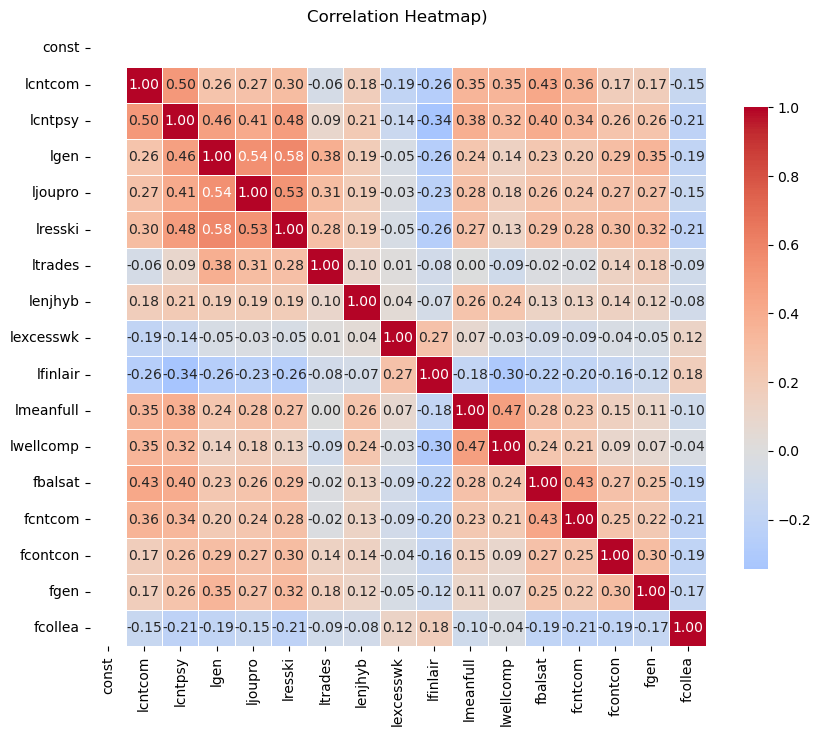

In [25]:
# Identify collinearity between variables
corr = X.corr()

plt.figure(figsize=(10,8))
sns.heatmap(
    corr,
    annot=True,
    cmap='coolwarm',
    center=0,
    linewidths=0.5,
    cbar_kws={"shrink": 0.75},
    fmt=".2f",
    square=True
)
plt.title(f"Correlation Heatmap)")
plt.show()

### Compare Explicit vs Implicit Predictors

In [35]:
X_full = df.iloc[:,17:]
X_full = sm.add_constant(X_full)
model_full = sm.OLS(y, X_full).fit()

X_explicit = df.iloc[:, 17:43]
X_explicit = sm.add_constant(X_explicit)
model_explicit = sm.OLS(y, X_explicit).fit()

X_implicit = df.iloc[:, 43:]
X_implicit = sm.add_constant(X_implicit)
model_implicit = sm.OLS(y, X_implicit).fit()

anova_imp = anova_lm(model_explicit, model_full)
print("Contribution of implicit factors (holding explicit constant):")
print(anova_imp)

# ANOVA: Do explicit factors improve model after implicit ones?
anova_exp = anova_lm(model_implicit, model_full)
print("\nContribution of explicit factors (holding implicit constant):")
print(anova_exp)

Contribution of implicit factors (holding explicit constant):
   df_resid          ssr  df_diff      ss_diff           F  Pr(>F)
0    4144.0  2655.663450      0.0          NaN         NaN     NaN
1    4118.0  1225.020578     26.0  1430.642873  184.969808     0.0

Contribution of explicit factors (holding implicit constant):
   df_resid          ssr  df_diff      ss_diff           F  Pr(>F)
0    4144.0  4829.521095      0.0          NaN         NaN     NaN
1    4118.0  1225.020578     26.0  3604.500517  466.030888     0.0


From the comparison, it is clear to see that the overall contribution of explicit factors for career preparedness is higher than for implicit factors

In [36]:
# For more comparison, let's check what the hypothesis test differences suggest

### 2. Analyse Key Themes and Drivers - Understand Fgen statistics

If I had time, I would specifically analyse the General comments to understand what that specifically entails

### 3. Show how factor importance varies by country

Using multi-level modelling

In [41]:
df['outcome'] = df['Preparedness Levels']
X = df[['lcntcom', 'lcntpsy', 'lgen', 'ljoupro', 'lresski', 'ltrades', 'lenjhyb', 'lexcesswk', 'lfinlair', 'lmeanfull', 'lwellcomp', 'fbalsat', 'fcntcom', 'fcontcon', 'fgen', 'fcollea']]

formula = 'outcome ~ ' + ' + '.join(X)

df['Country'] = df['Country'].astype('category')

In [42]:
model = smf.mixedlm(formula, df, groups=df["Country"])
result = model.fit()
print(result.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: outcome   
No. Observations: 4171    Method:             REML      
No. Groups:       6       Scale:              0.2947    
Min. group size:  580     Log-Likelihood:     -3490.4888
Max. group size:  1193    Converged:          Yes       
Mean group size:  695.2                                 
--------------------------------------------------------
             Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept     5.359    0.049 109.498 0.000  5.263  5.454
lcntcom      -0.001    0.000  -2.689 0.007 -0.001 -0.000
lcntpsy      -0.000    0.000  -1.196 0.232 -0.001  0.000
lgen          0.021    0.000  87.768 0.000  0.020  0.021
ljoupro       0.001    0.000   2.625 0.009  0.000  0.001
lresski       0.001    0.000   3.960 0.000  0.000  0.001
ltrades       0.001    0.000   7.039 0.000  0.001  0.002
lenjhyb       0.001    0.000   4.208 0.00

/Users/raymondguo/opt/anaconda3/envs/cowryenv/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [43]:
country_effects = pd.DataFrame(result.random_effects).T
country_effects.columns = ['intercept']
country_effects = country_effects.sort_values(by='intercept', ascending=False)

<Figure size 1000x600 with 0 Axes>

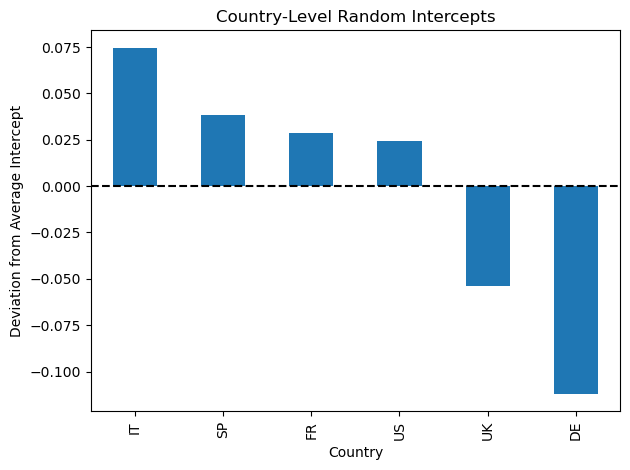

In [44]:
plt.figure(figsize=(10, 6))
country_effects.plot(kind='bar', legend=False)
plt.axhline(0, color='black', linestyle='--')
plt.title("Country-Level Random Intercepts")
plt.ylabel("Deviation from Average Intercept")
plt.xlabel("Country")
plt.tight_layout()
plt.show()